# Aftershock Forecasting with Machine Learning
This notebook covers loading earthquake catalog data, identifying mainshock–aftershock sequences, engineering features, training models, and analyzing results to predict aftershock counts.

## 📥 Load and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv('data.csv')
df['time'] = pd.to_datetime(df['time'], format='mixed')
df = df.sort_values('time')
df.head()

,time,latitude,longitude,depth,magnitude,evid
0,1932-01-01 23:52:07.870000,34.130000,-117.993000,6.0,0.0,3358386
1,1932-01-02 16:42:43.679999,33.902500,-117.645000,6.0,2.7,3358387
2,1932-01-03 17:58:10.009999,32.000000,-116.000000,6.0,3.0,3358388
3,1932-01-04 21:30:00.960000,33.771167,-117.494167,6.0,2.0,3358396
4,1932-01-05 02:37:27.960000,33.559500,-118.441667,6.0,1.5,3358398


## 🔍 Identify Mainshocks and Extract Aftershock Counts

In [ ]:
import pandas as pd

# === PARAMETERS ===
RADIUS_KM = 100
DEG_LAT_KM = 111#check
LAT_BUFFER = RADIUS_KM / DEG_LAT_KM
LON_BUFFER = RADIUS_KM / DEG_LAT_KM
WINDOW_DAYS = 30
MIN_MAG = 4.5


# === NON-OVERLAPPING MAINSHOCK FILTER ===
def get_non_overlapping_mainshocks(catalog, min_magnitude=MIN_MAG, window_days=WINDOW_DAYS):
    candidates = catalog[catalog["magnitude"] >= min_magnitude].sort_values("time").reset_index(drop=True)

    #return candidates
    non_overlapping = []

    for _, quake in candidates.iterrows():
        t0 = quake["time"]
        lat0 = quake["latitude"]
        lon0 = quake["longitude"]
        is_overlap = False

        for prev in non_overlapping:
            time_diff = (t0 - prev["time"]).days
            if 0 <= time_diff <= window_days:
                if (
                    abs(lat0 - prev["latitude"]) <= LAT_BUFFER and
                    abs(lon0 - prev["longitude"]) <= LON_BUFFER
                ):
                    is_overlap = True
                    break

        if not is_overlap:
            non_overlapping.append(quake)

    return pd.DataFrame(non_overlapping)

# === FAST AFTERSHOCK COUNTER ===
def count_aftershocks_fast(mainshock, catalog, thresholds=[2.0, 3.0, 4.0], window_days=WINDOW_DAYS):
    t0 = mainshock['time']
    t1 = t0 + pd.Timedelta(days=window_days)
    lat0, lon0 = mainshock['latitude'], mainshock['longitude']

    # Temporal filter
    mask_time = (catalog['time'] > t0) & (catalog['time'] <= t1)
    candidates = catalog[mask_time]

    # Bounding box filter
    mask_space = (
        (candidates['latitude'] >= lat0 - LAT_BUFFER) &
        (candidates['latitude'] <= lat0 + LAT_BUFFER) &
        (candidates['longitude'] >= lon0 - LON_BUFFER) &
        (candidates['longitude'] <= lon0 + LON_BUFFER)
    )
    candidates = candidates[mask_space]

    # Count by magnitude threshold
    counts = {f'count_m{t}': (candidates['magnitude'] >= t).sum() for t in thresholds}
    return pd.Series({
        'mainshock_time': t0,
        'mainshock_lat': lat0,
        'mainshock_lon': lon0,
        'mainshock_mag': mainshock['magnitude'],
        'mainshock_depth': mainshock['depth'],
        **counts
    })

# === RUN MAIN CODE ===
mainshocks = get_non_overlapping_mainshocks(df)
print(f"# Mainshocks (non-overlapping): {len(mainshocks)}")

data = mainshocks.apply(lambda row: count_aftershocks_fast(row, df), axis=1).reset_index(drop=True)

# Mainshocks (non-overlapping): 391


In [ ]:
mainshocks.describe()

,time,latitude,longitude,depth,magnitude,evid
count,391,391.000000,391.000000,391.000000,391.000000,3.910000e+02
mean,1977-10-22 17:56:27.074935648,34.178498,-117.561709,7.471823,4.937084,7.901082e+06
min,1932-03-23 00:20:06.500000,32.000000,-121.822333,-0.851200,4.500000,1.103900e+04
25%,1953-12-04 21:15:21.264998976,33.062583,-118.777833,5.995000,4.600000,3.297272e+06
50%,1980-02-25 10:47:38.409998976,34.064000,-117.304167,6.000000,4.800000,3.358681e+06
75%,2000-10-19 06:24:06.664999552,35.187833,-116.048583,9.715000,5.100000,9.871340e+06
max,2024-10-25 08:05:08.289999,36.945000,-114.461333,31.830000,7.500000,4.096413e+07
std,NaN,1.326817,1.851521,4.333236,0.517965,1.020107e+07


In [ ]:
data.__len__()

391

Analysis

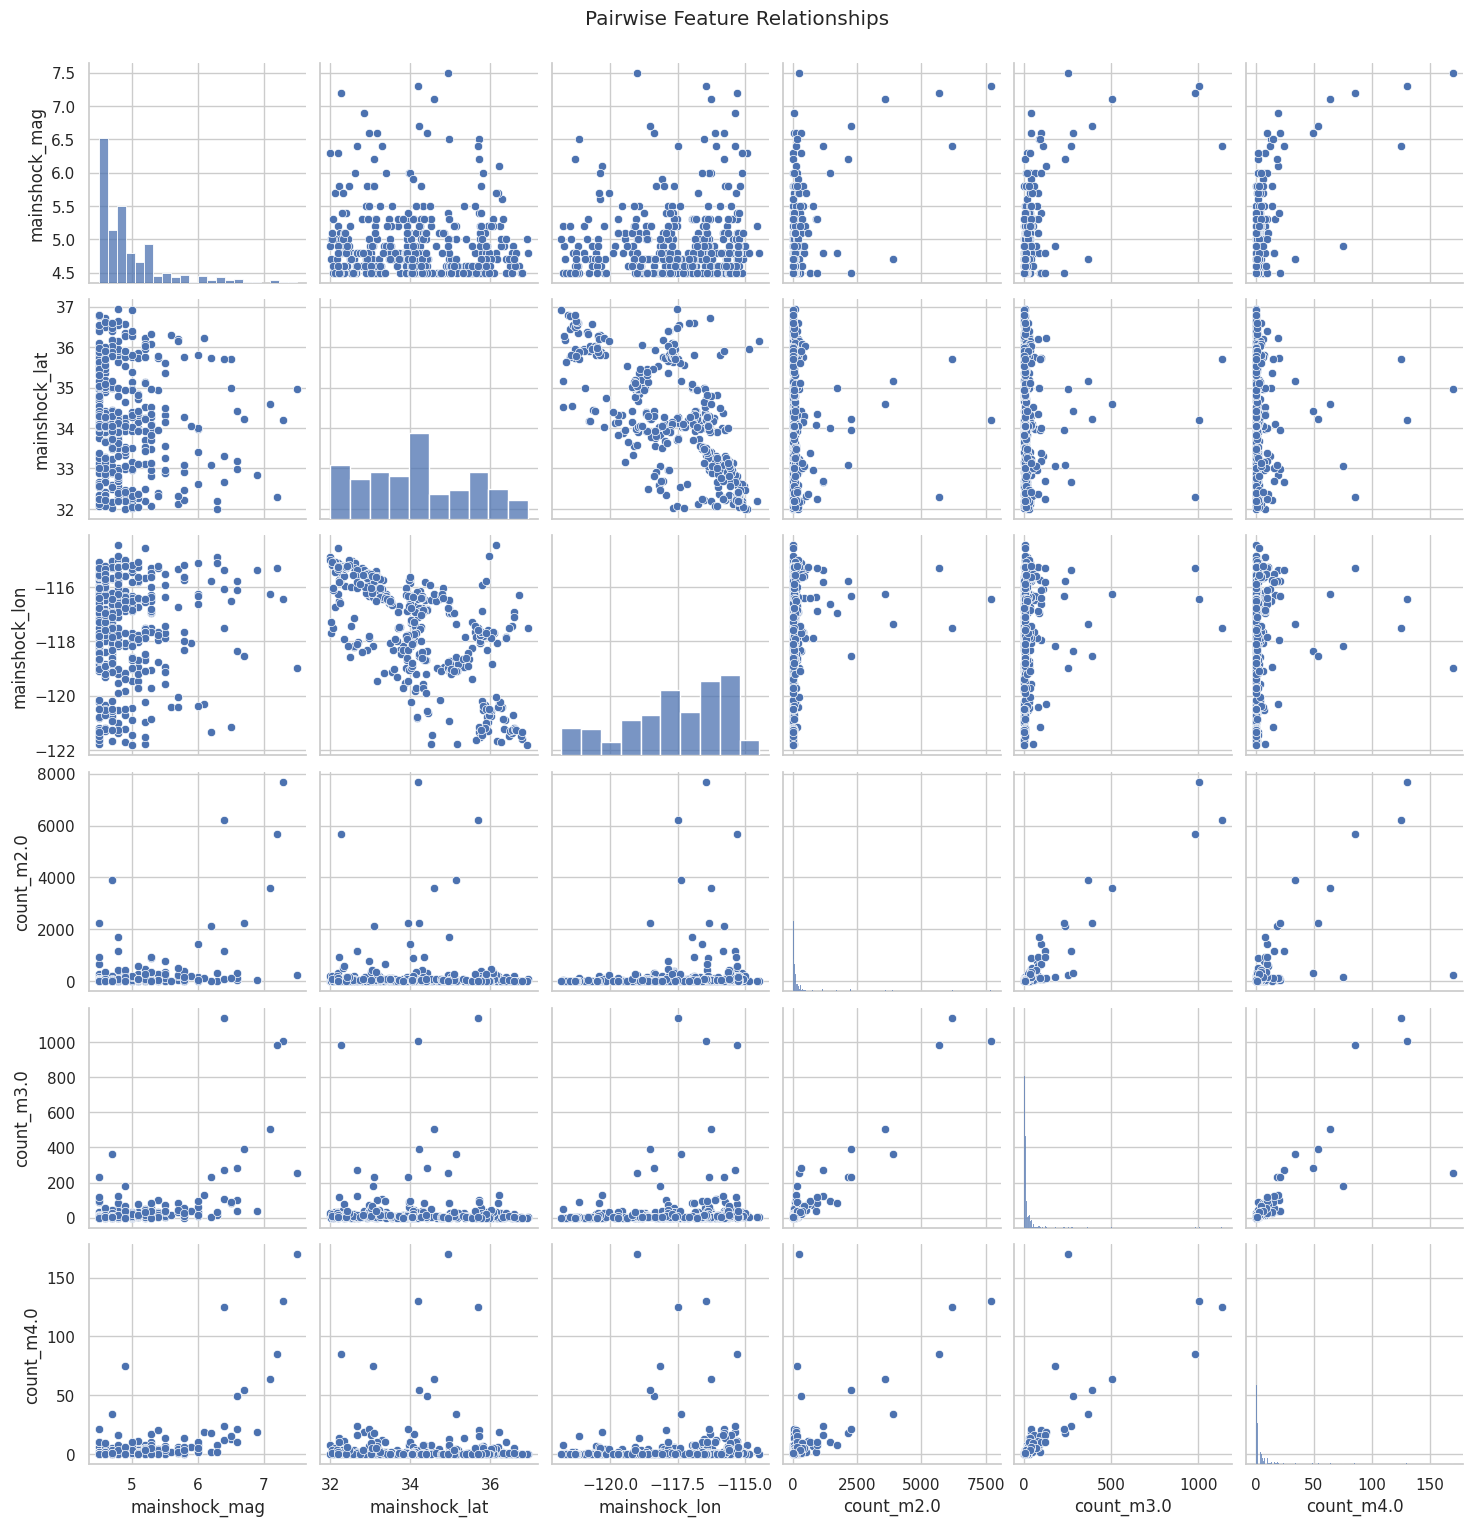

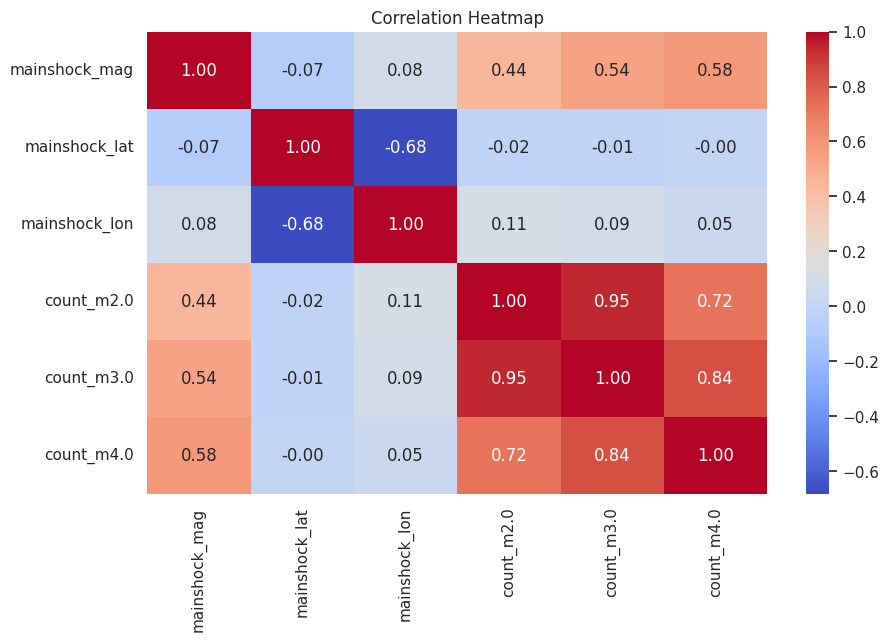

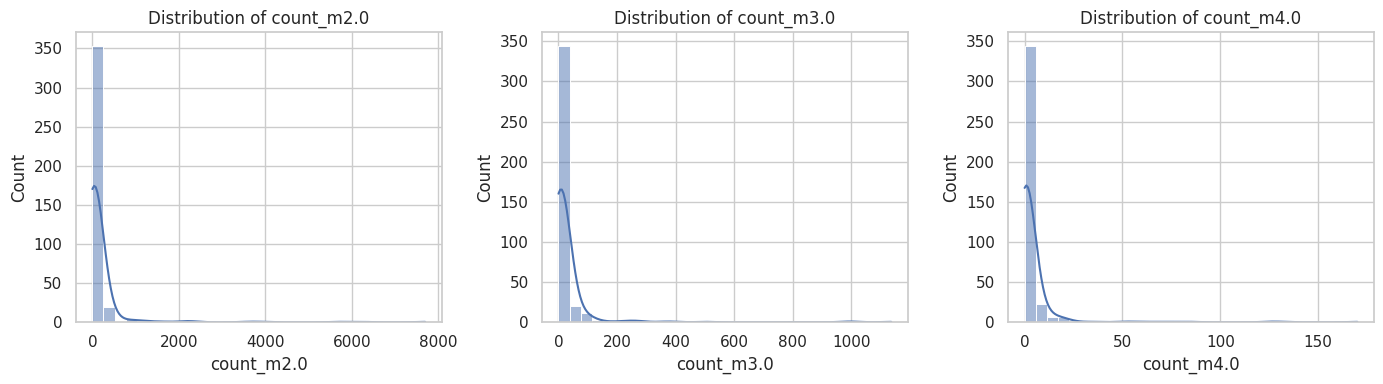

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


features = ['mainshock_mag', 'mainshock_lat', 'mainshock_lon']
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

# Set plot style
sns.set(style="whitegrid")

# 1. Pairplot of features and targets
pairplot_data = data[features + targets]
sns.pairplot(pairplot_data)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pairplot_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 3. Histograms of target distributions
plt.figure(figsize=(14, 4))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[target], bins=30, kde=True)
    plt.title(f"Distribution of {target}")
plt.tight_layout()
plt.show()

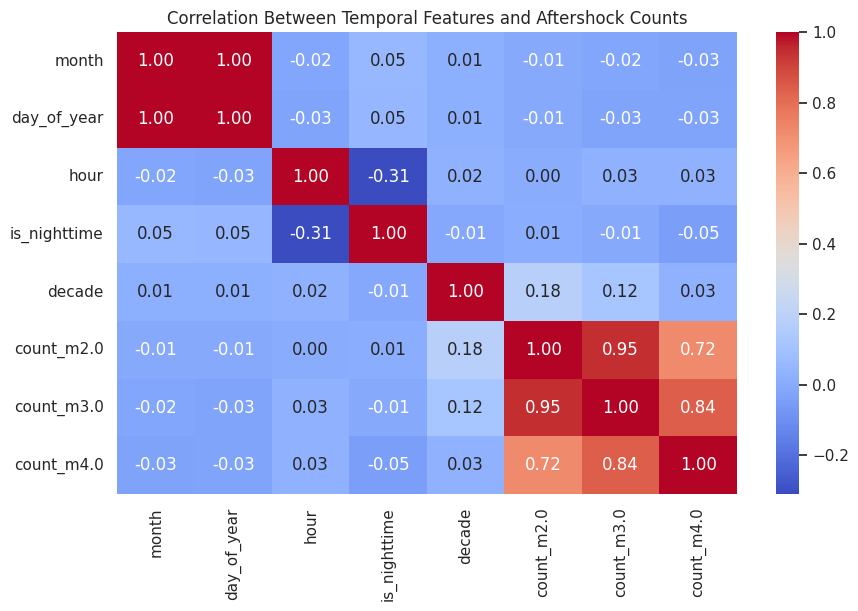

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Copy data for feature engineering
feature_data = data.copy()

# Extract temporal features
feature_data["month"] = feature_data["mainshock_time"].dt.month
feature_data["day_of_year"] = feature_data["mainshock_time"].dt.dayofyear
feature_data["hour"] = feature_data["mainshock_time"].dt.hour
feature_data["is_nighttime"] = feature_data["hour"].apply(lambda h: 1 if h <= 6 or h >= 22 else 0)
feature_data["decade"] = (feature_data["mainshock_time"].dt.year // 10) * 10


# Define features and targets
temporal_features = ["month", "day_of_year", "hour", "is_nighttime", "decade"]
targets = ["count_m2.0", "count_m3.0", "count_m4.0"]

# Plot correlations using a heatmap
correlation_data = feature_data[temporal_features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Temporal Features and Aftershock Counts")
plt.show()


In [ ]:
from datetime import timedelta

def compute_seismic_history_features(mainshock, catalog, history_days=30, radius_km=100):
    t0 = mainshock["mainshock_time"]
    t_hist = t0 - pd.Timedelta(days=history_days)
    lat0, lon0 = mainshock["mainshock_lat"], mainshock["mainshock_lon"]

    # Filter events within the history window
    mask_time = (catalog["time"] > t_hist) & (catalog["time"] < t0)
    candidates = catalog[mask_time]

    # Apply bounding box spatial filter
    lat_buffer = RADIUS_KM / DEG_LAT_KM
    lon_buffer = RADIUS_KM / DEG_LAT_KM
    mask_space = (
        (candidates["latitude"] >= lat0 - lat_buffer) &
        (candidates["latitude"] <= lat0 + lat_buffer) &
        (candidates["longitude"] >= lon0 - lon_buffer) &
        (candidates["longitude"] <= lon0 + lon_buffer)
    )
    candidates = candidates[mask_space]

    # Compute features
    num_prior_events = len(candidates)
    avg_mag_prior = candidates["magnitude"].mean() if num_prior_events > 0 else 0
    total_energy_prior = (10 ** (1.5 * candidates["magnitude"])).sum() if num_prior_events > 0 else 0

    return pd.Series({
        "num_prior_events_30d": num_prior_events,
        "avg_mag_prior_30d": avg_mag_prior,
        "energy_release_prior_30d": total_energy_prior
    })

# Apply to feature_data


# Apply the seismic history feature extraction
seismic_features = feature_data.apply(lambda row: compute_seismic_history_features(row, df), axis=1)

# Fill any NaNs with safe defaults
seismic_features.fillna({
    "avg_mag_prior_30d": 0,
    "energy_release_prior_30d": 0
}, inplace=True)

# Merge with the rest of the data
feature_data_full = pd.concat([feature_data.reset_index(drop=True), seismic_features], axis=1)



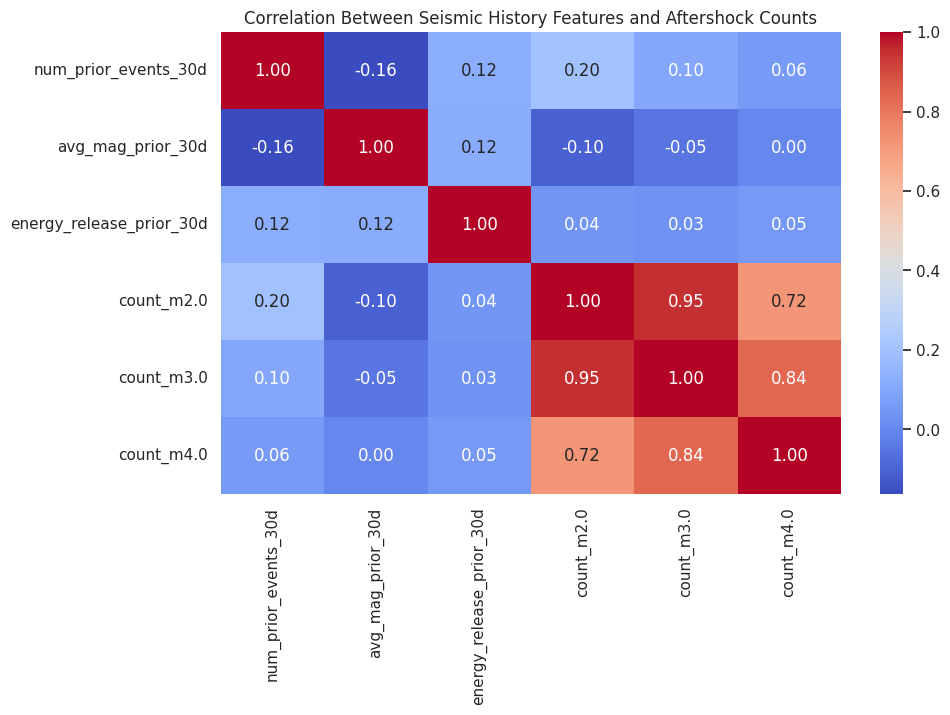

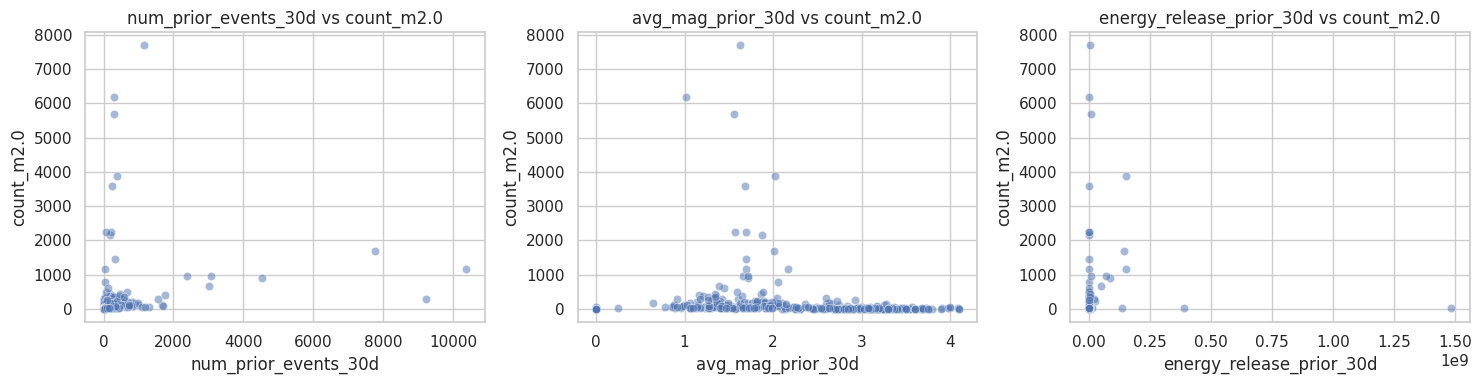

In [ ]:
# Correlation heatmap between seismic history features and aftershock counts
seismic_features = ["num_prior_events_30d", "avg_mag_prior_30d", "energy_release_prior_30d"]
targets = ["count_m2.0", "count_m3.0", "count_m4.0"]

correlation_data = feature_data_full[seismic_features + targets].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Seismic History Features and Aftershock Counts")
plt.show()

# Scatter plots
plt.figure(figsize=(15, 4))
for i, feature in enumerate(seismic_features):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(data=feature_data_full, x=feature, y="count_m2.0", alpha=0.5)
    plt.title(f"{feature} vs count_m2.0")
    plt.xlabel(feature)
    plt.ylabel("count_m2.0")
plt.tight_layout()
plt.show()

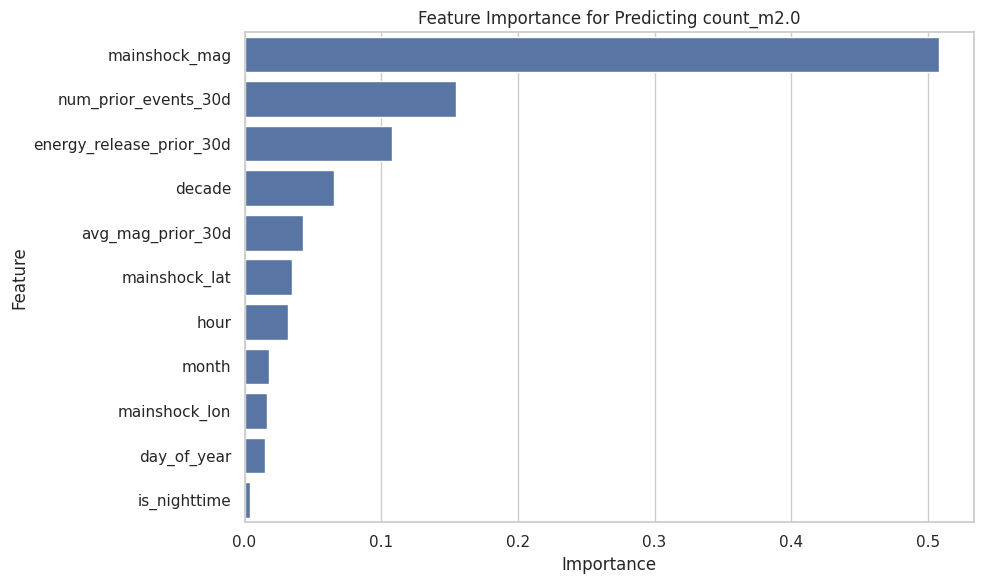

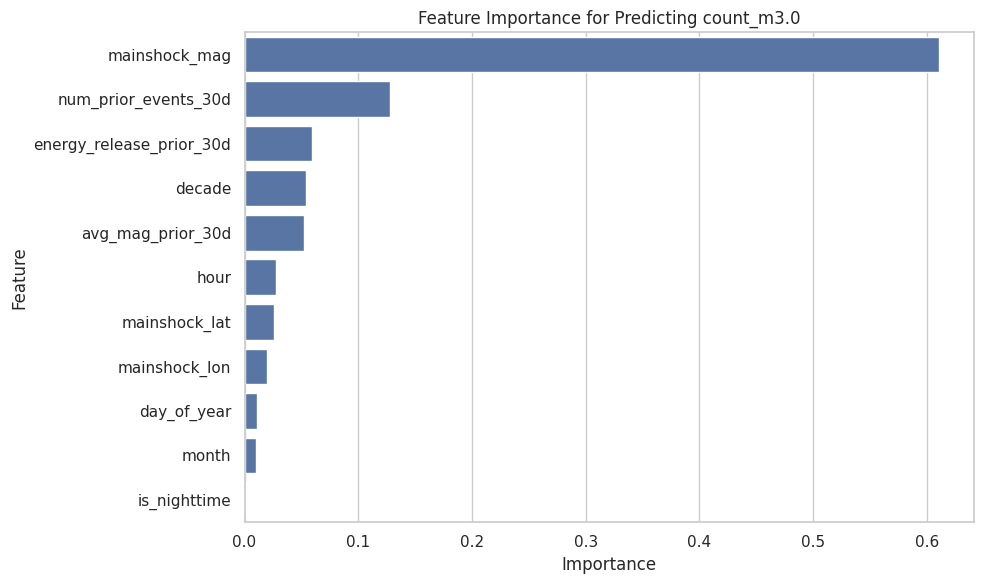

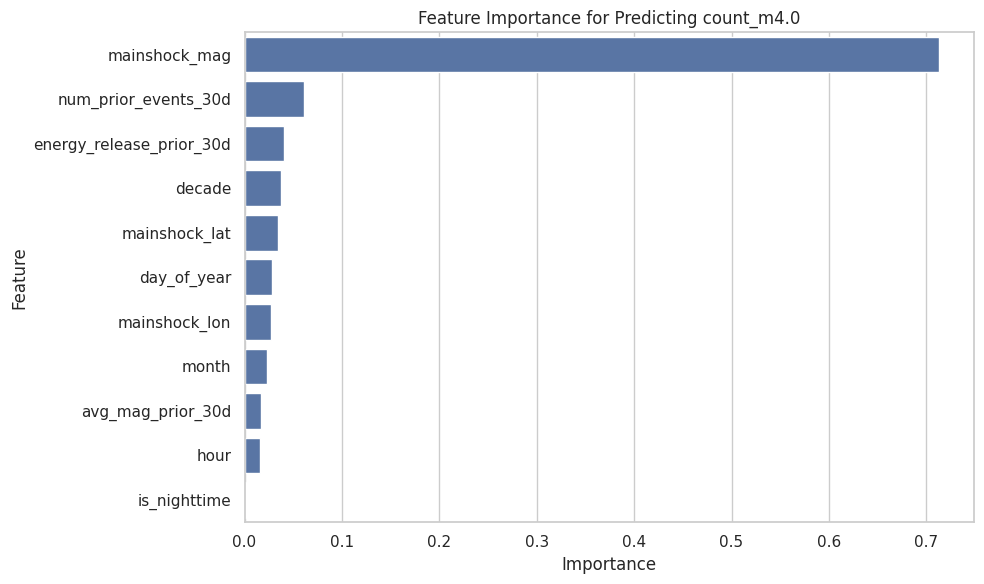

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define feature set and target
all_features = [
    "mainshock_mag", "mainshock_lat", "mainshock_lon",
    "month", "day_of_year", "hour", "is_nighttime", "decade",
    "num_prior_events_30d", "avg_mag_prior_30d", "energy_release_prior_30d"
]

# Prepare the data
X = feature_data_full[all_features]
y = feature_data_full["count_m2.0"]  # We'll analyze feature importances for predicting count_m2.0

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance for Predicting count_m2.0")
plt.tight_layout()
plt.show()

importance_results = {}

for target in ["count_m3.0", "count_m4.0"]:
    y_target = feature_data_full[target]
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y_target)

    importance_df = pd.DataFrame({
        "Feature": all_features,
        "Importance": rf_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    importance_results[target] = importance_df

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(f"Feature Importance for Predicting {target}")
    plt.tight_layout()
    plt.show()


## 🛠️ Feature Engineering: Temporal & Seismic History

In [ ]:
# Temporal features
data['month'] = data['mainshock_time'].dt.month
data['day_of_year'] = data['mainshock_time'].dt.dayofyear
data['hour'] = data['mainshock_time'].dt.hour
data['is_nighttime'] = data['hour'].apply(lambda h: 1 if h <= 6 or h >= 22 else 0)
data['decade'] = (data['mainshock_time'].dt.year // 10) * 10

# Seismic history features
def compute_seismic_history_features(mainshock, catalog, history_days=30):
    t0 = mainshock['mainshock_time']
    t_hist = t0 - pd.Timedelta(days=history_days)
    lat0, lon0 = mainshock['mainshock_lat'], mainshock['mainshock_lon']
    mask_time = (catalog['time'] > t_hist) & (catalog['time'] < t0)
    candidates = catalog[mask_time]
    mask_space = (
        (candidates['latitude'] >= lat0 - LAT_BUFFER) &
        (candidates['latitude'] <= lat0 + LAT_BUFFER) &
        (candidates['longitude'] >= lon0 - LON_BUFFER) &
        (candidates['longitude'] <= lon0 + LON_BUFFER)
    )
    candidates = candidates[mask_space]
    num = len(candidates)
    avg_mag = candidates['magnitude'].mean() if num > 0 else 0
    energy = (10 ** (1.5 * candidates['magnitude'])).sum() if num > 0 else 0
    return pd.Series({
        'num_prior_events_30d': num,
        'avg_mag_prior_30d': avg_mag,
        'energy_release_prior_30d': energy

    })

history_feats = data.apply(lambda row: compute_seismic_history_features(row, df), axis=1)
data = pd.concat([data.reset_index(drop=True), history_feats], axis=1)
data.head()

,mainshock_time,mainshock_lat,mainshock_lon,mainshock_mag,mainshock_depth,count_m2.0,count_m3.0,count_m4.0,month,day_of_year,hour,is_nighttime,decade,num_prior_events_30d,avg_mag_prior_30d,energy_release_prior_30d
0,1932-03-23 00:20:06.500000,35.795333,-115.932333,4.5,6.0,1,0,0,3,83,0,1,1930,0.0,0.000000,0.000000e+00
1,1932-10-09 22:50:41.450000,32.640000,-115.430000,4.5,6.0,19,10,2,10,283,22,1,1930,15.0,3.186667,3.041916e+06
2,1932-10-19 16:39:39.399999,36.165000,-121.681500,4.7,6.0,1,1,1,10,293,16,0,1930,0.0,0.000000,0.000000e+00
3,1933-02-24 19:33:17.510000,33.063000,-118.163000,4.9,6.0,181,179,75,2,55,19,0,1930,2.0,2.650000,1.916347e+04
4,1933-06-26 06:27:47.850000,34.033500,-120.251000,4.5,6.0,2,1,0,6,177,6,1,1930,5.0,3.340000,4.175382e+06


## 🤖 Model Training and Evaluation

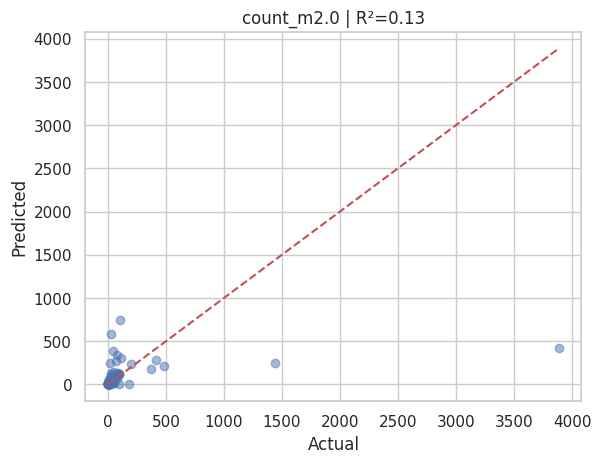

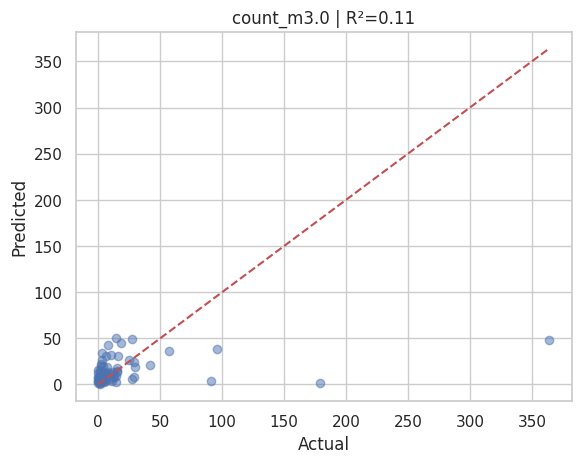

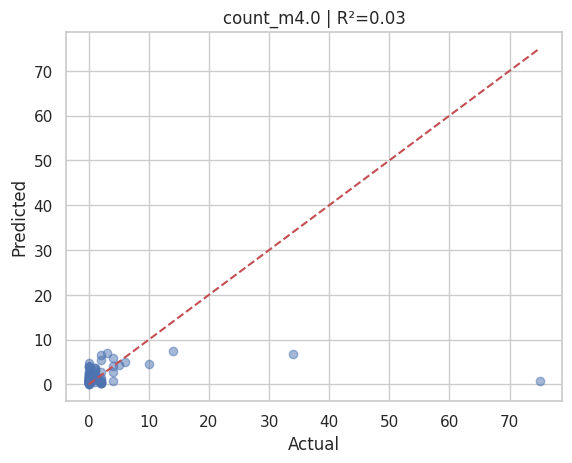

{'count_m2.0': {'MAE': 115.896582278481, 'R2': 0.12981637863830076},
 'count_m3.0': {'MAE': 16.345569620253162, 'R2': 0.10828749593150921},
 'count_m4.0': {'MAE': 2.7713924050632905, 'R2': 0.029663772829622403}}

In [ ]:
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon','mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = {}
for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}
    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()
metrics

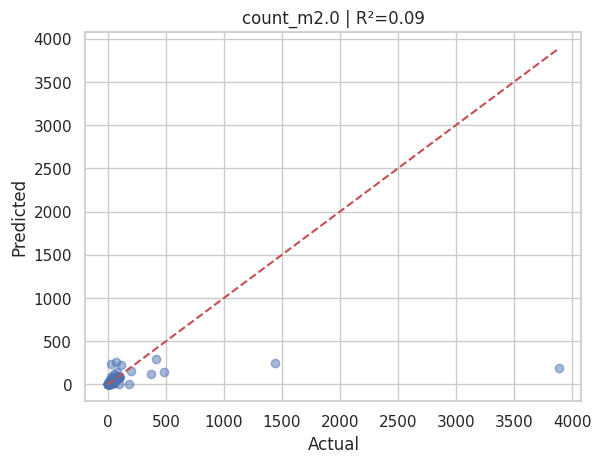

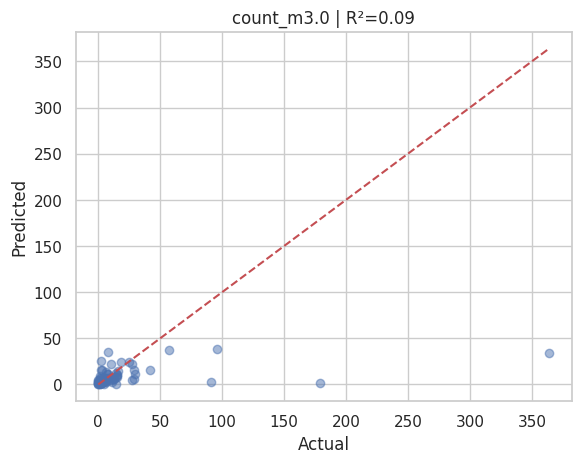

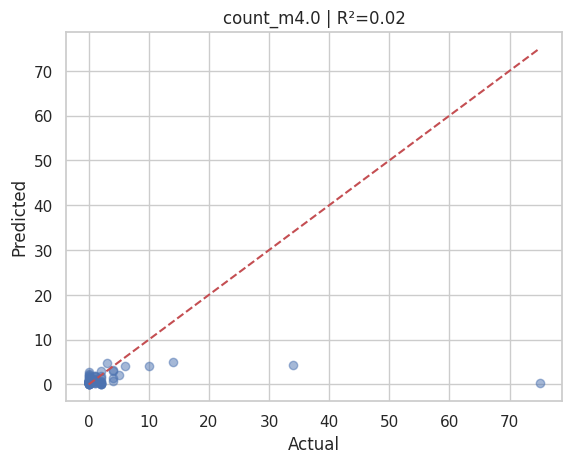

{'count_m2.0': {'MAE': 90.9805843828126, 'R2': 0.08556459205980471},
 'count_m3.0': {'MAE': 13.291224966076026, 'R2': 0.08742378017727226},
 'count_m4.0': {'MAE': 2.350580921719362, 'R2': 0.016377021551750803}}

In [ ]:
##trial 2: with log transform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Features and Targets
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon','mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log-transform helper functions
def log_transform(y): return np.log1p(y)
def inverse_log_transform(y): return np.expm1(y)

# Train & Evaluate
metrics = {}

for target in targets:
    # Log-transform the target
    y_train_log = log_transform(y_train[target])
    y_test_log = log_transform(y_test[target])

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_log)

    # Predict and inverse transform
    pred_log = model.predict(X_test)
    pred = inverse_log_transform(pred_log)

    # Evaluation
    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    # Plot
    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

metrics


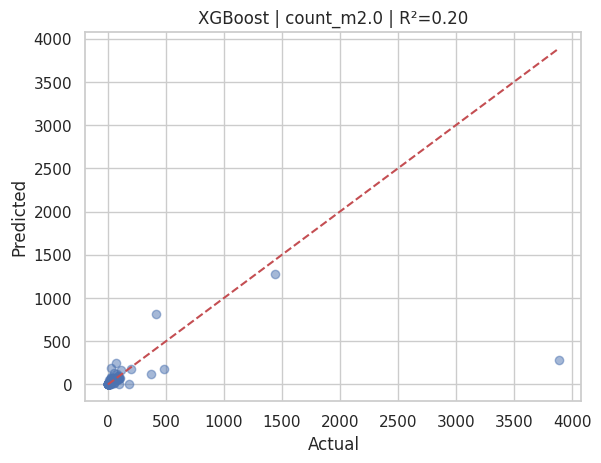

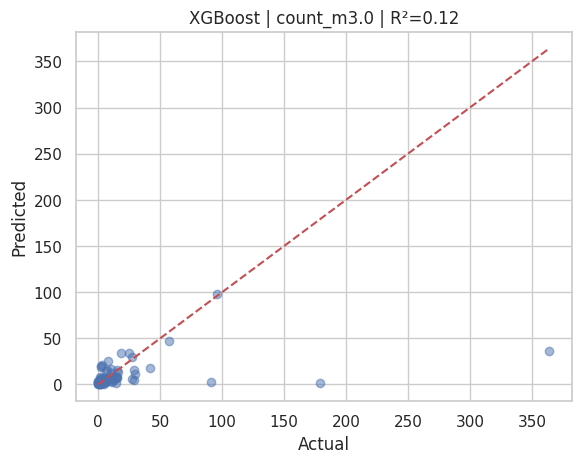

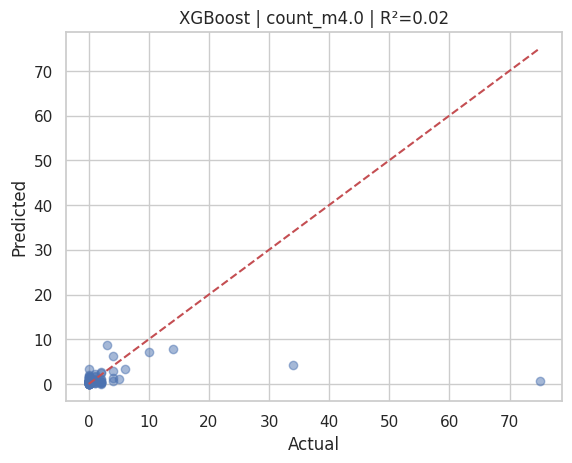

In [ ]:
#trial 3: XGBoost Regressor
import xgboost as xgb

metrics_xgb = {}

for target in targets:
    y_train_log = np.log1p(y_train[target])
    y_test_log = np.log1p(y_test[target])

    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train_log)
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics_xgb[target] = {'MAE': mae, 'R2': r2}

    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'XGBoost | {target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 12
[LightGBM] [Info] Start training from score 3.436923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

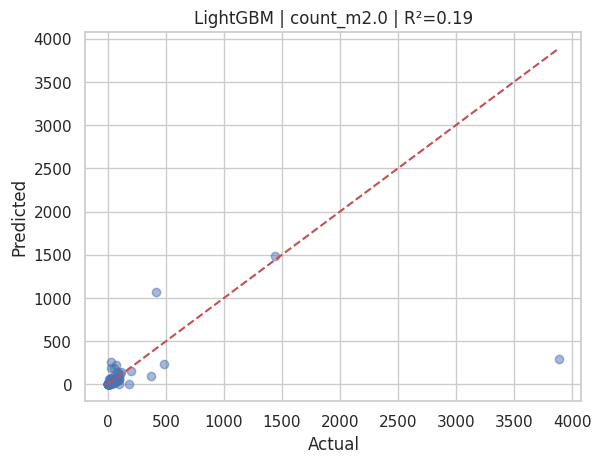

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 12
[LightGBM] [Info] Start training from score 2.143635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

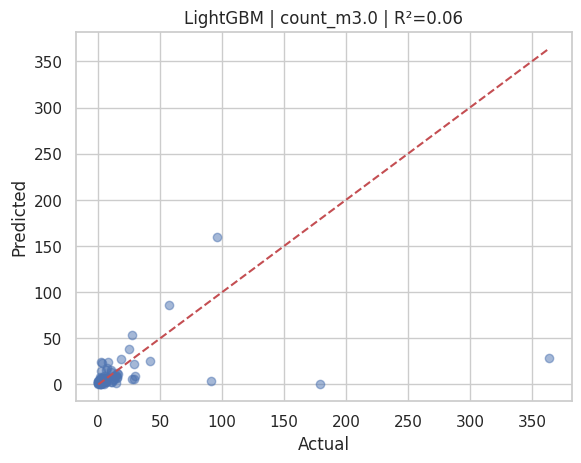

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 12
[LightGBM] [Info] Start training from score 0.761787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

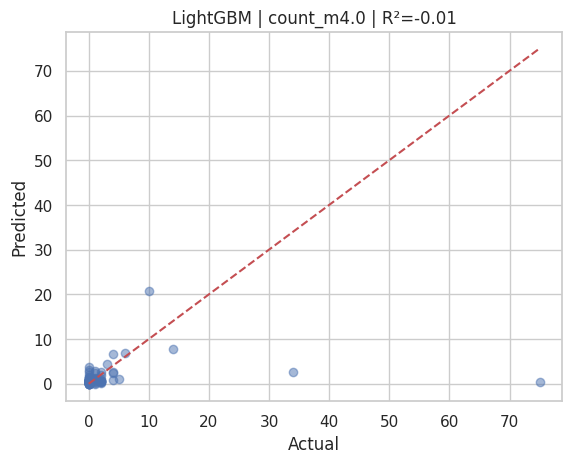

In [ ]:
#trial 4: lightgbm
import lightgbm as lgb

metrics_lgb = {}

for target in targets:
    y_train_log = np.log1p(y_train[target])
    y_test_log = np.log1p(y_test[target])

    model = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train_log)
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics_lgb[target] = {'MAE': mae, 'R2': r2}

    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'LightGBM | {target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()


In [ ]:
#trial 4: adding temporal features to random forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pprint

# Load dataset
df = pd.read_csv("data.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Constants
RADIUS_KM = 100
DEG_LAT_KM = 111
LAT_BUFFER = RADIUS_KM / DEG_LAT_KM
LON_BUFFER = RADIUS_KM / DEG_LAT_KM
WINDOW_DAYS = 30
MIN_MAG = 4.5

# Filter mainshocks
def get_non_overlapping_mainshocks(catalog, min_magnitude=MIN_MAG, window_days=WINDOW_DAYS):
    candidates = catalog[catalog["magnitude"] >= min_magnitude].sort_values("time").reset_index(drop=True)
    non_overlapping = []
    for _, quake in candidates.iterrows():
        t0 = quake["time"]
        lat0, lon0 = quake["latitude"], quake["longitude"]
        is_overlap = any(
            (0 <= (t0 - prev["time"]).days <= window_days) and
            (abs(lat0 - prev["latitude"]) <= LAT_BUFFER) and
            (abs(lon0 - prev["longitude"]) <= LON_BUFFER)
            for prev in non_overlapping
        )
        if not is_overlap:
            non_overlapping.append(quake)
    return pd.DataFrame(non_overlapping)

# Count aftershocks
def count_aftershocks_fast(mainshock, catalog, thresholds=[2.0, 3.0, 4.0], window_days=WINDOW_DAYS):
    t0 = mainshock['time']
    t1 = t0 + pd.Timedelta(days=window_days)
    lat0, lon0 = mainshock['latitude'], mainshock['longitude']
    mask_time = (catalog['time'] > t0) & (catalog['time'] <= t1)
    mask_space = (
        (catalog['latitude'] >= lat0 - LAT_BUFFER) &
        (catalog['latitude'] <= lat0 + LAT_BUFFER) &
        (catalog['longitude'] >= lon0 - LON_BUFFER) &
        (catalog['longitude'] <= lon0 + LON_BUFFER)
    )
    candidates = catalog[mask_time & mask_space]
    counts = {f'count_m{t}': (candidates['magnitude'] >= t).sum() for t in thresholds}
    return pd.Series({
        'mainshock_time': t0,
        'mainshock_lat': lat0,
        'mainshock_lon': lon0,
        'mainshock_mag': mainshock['magnitude'],
        'mainshock_depth': mainshock['depth'],
        **counts
    })

# Apply pipeline
mainshocks = get_non_overlapping_mainshocks(df)
data = mainshocks.apply(lambda row: count_aftershocks_fast(row, df), axis=1).reset_index(drop=True)

# Add temporal features
data['mainshock_time'] = pd.to_datetime(data['mainshock_time'])
data['hour'] = data['mainshock_time'].dt.hour
data['month'] = data['mainshock_time'].dt.month
data['day_of_year'] = data['mainshock_time'].dt.dayofyear
data['weekday'] = data['mainshock_time'].dt.weekday
data['is_nighttime'] = data['hour'].apply(lambda h: h < 6 or h >= 20)

# Train model with temporal features
features = ['mainshock_mag', 'mainshock_lat', 'mainshock_lon', 'mainshock_depth',
            'hour', 'month', 'day_of_year', 'weekday', 'is_nighttime']
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Evaluate for each target
results = {}
for target in targets:
    results[target] = evaluate_model(data[features], data[target])

# Show results
pprint.pprint(results)


{'count_m2.0': {'MAE': 143.6184693877551, 'R2': 0.5949202674896201},
 'count_m3.0': {'MAE': 21.4934693877551, 'R2': 0.6156293563701588},
 'count_m4.0': {'MAE': 2.8117346938775505, 'R2': 0.4531858825410081}}


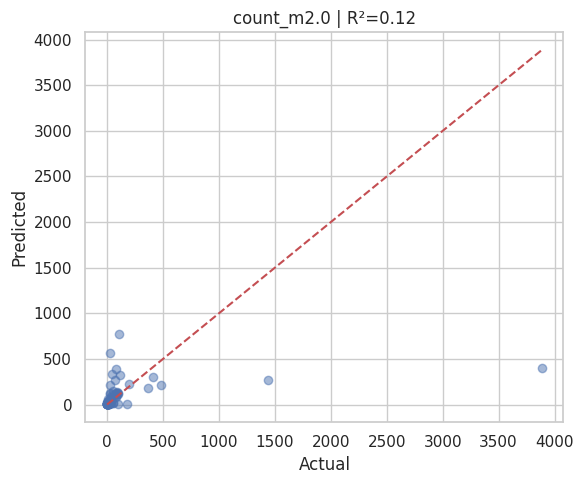

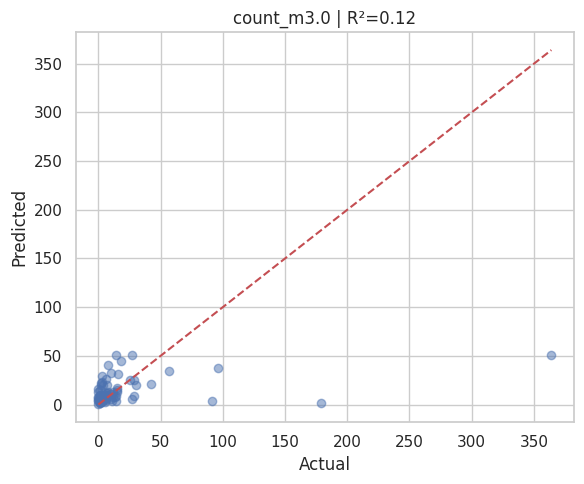

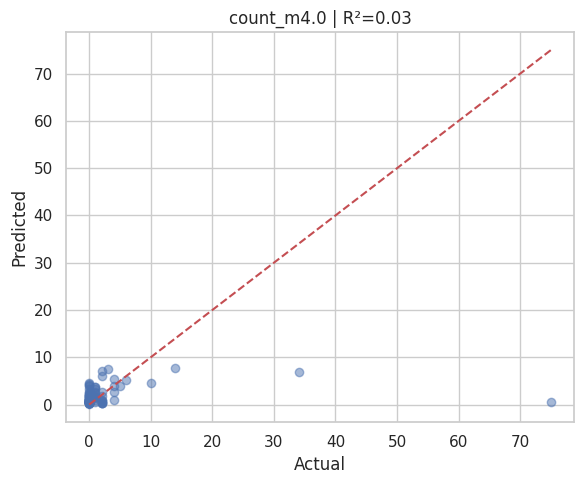

{'count_m2.0': {'MAE': 115.1513924050633, 'R2': 0.12448939710091467},
 'count_m3.0': {'MAE': 16.008481012658226, 'R2': 0.12062965137375203},
 'count_m4.0': {'MAE': 2.777594936708861, 'R2': 0.027999294433511568}}

In [ ]:
#trial 4-2:
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Seismic history feature function ===
def compute_history(row, catalog, history_days=30, radius_km=100):
    t0 = row["mainshock_time"]
    lat0, lon0 = row["mainshock_lat"], row["mainshock_lon"]
    t_hist = t0 - pd.Timedelta(days=history_days)

    DEG_LAT_KM = 111
    lat_buffer = radius_km / DEG_LAT_KM
    lon_buffer = radius_km / DEG_LAT_KM

    mask = (
        (catalog["time"] < t0) &
        (catalog["time"] >= t_hist) &
        (catalog["latitude"] >= lat0 - lat_buffer) &
        (catalog["latitude"] <= lat0 + lat_buffer) &
        (catalog["longitude"] >= lon0 - lon_buffer) &
        (catalog["longitude"] <= lon0 + lon_buffer)
    )
    nearby = catalog[mask]

    count = len(nearby)
    avg_mag = nearby["magnitude"].mean() if count > 0 else 0
    energy = (10 ** (1.5 * nearby["magnitude"] + 4.8)).sum() if count > 0 else 0

    return pd.Series({
        'num_prior_events_30d': count,
        'avg_mag_prior_30d': avg_mag,
        'energy_release_prior_30d': energy
    })

# === Step 2: Add required features ===
data['mainshock_time'] = pd.to_datetime(data['mainshock_time'])
df['time'] = pd.to_datetime(df['time'])

# Temporal
data['hour'] = data['mainshock_time'].dt.hour
data['month'] = data['mainshock_time'].dt.month
data['day_of_year'] = data['mainshock_time'].dt.dayofyear
data['is_nighttime'] = data['hour'].apply(lambda h: h < 6 or h >= 20)
data['decade'] = (data['mainshock_time'].dt.year // 10) * 10

# Seismic history
history_feats = data.apply(lambda row: compute_history(row, df), axis=1)
data = pd.concat([data, history_feats], axis=1)

# Fill missing values if any
data.fillna({
    'num_prior_events_30d': 0,
    'avg_mag_prior_30d': 0.0,
    'energy_release_prior_30d': 0.0
}, inplace=True)

# === Step 3: Modeling ===
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon', 'mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = {}
for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target].max(), pred.max())], [0, max(y_test[target].max(), pred.max())], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final metrics
metrics



Training model for: count_m2.0


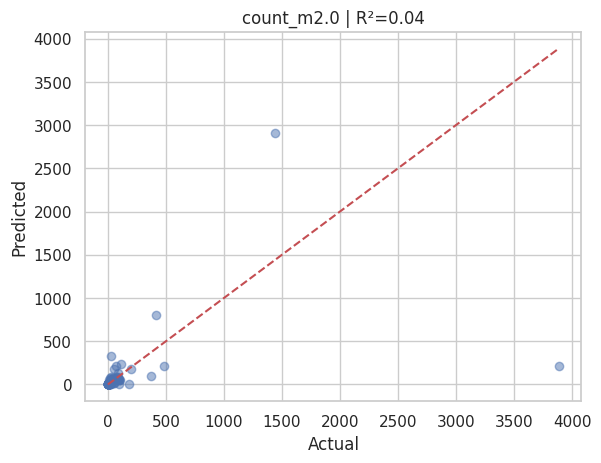


Training model for: count_m3.0


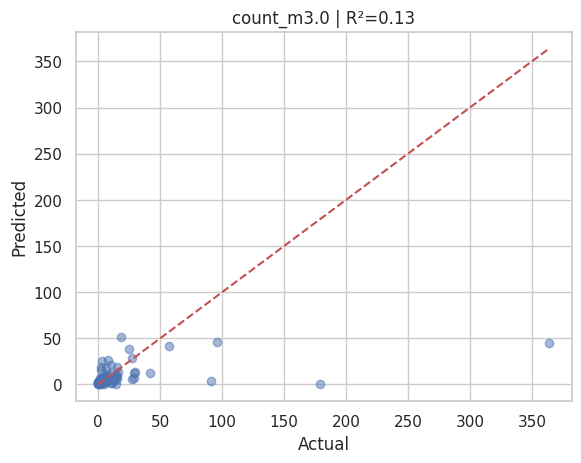


Training model for: count_m4.0


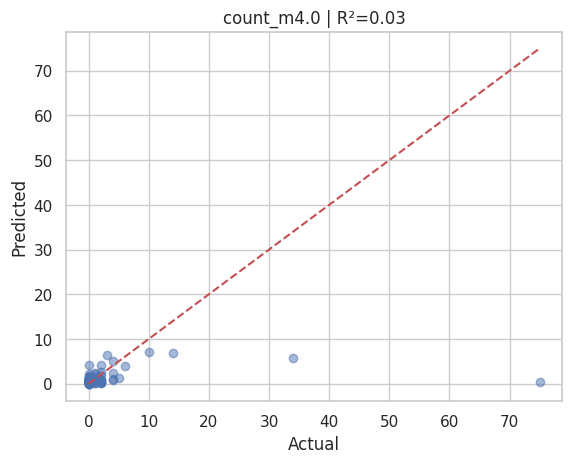


Model Evaluation Metrics:
count_m2.0: MAE=100.75, R²=0.04
count_m3.0: MAE=13.67, R²=0.13
count_m4.0: MAE=2.35, R²=0.03


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# === Features and Targets ===
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon','mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Modeling ===
metrics = {}

for target in targets:
    print(f"\nTraining model for: {target}")

    # Log-transform the target to reduce skew
    y_train_log = np.log1p(y_train[target])

    # Initialize XGBoost model
    model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )

    # Fit model
    model.fit(X_train, y_train_log)

    # Predict (and invert log)
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)  # back to original scale

    # Evaluate
    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    # Plot
    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

# === Final metrics summary ===
print("\nModel Evaluation Metrics:")
for t, m in metrics.items():
    print(f"{t}: MAE={m['MAE']:.2f}, R²={m['R2']:.2f}")


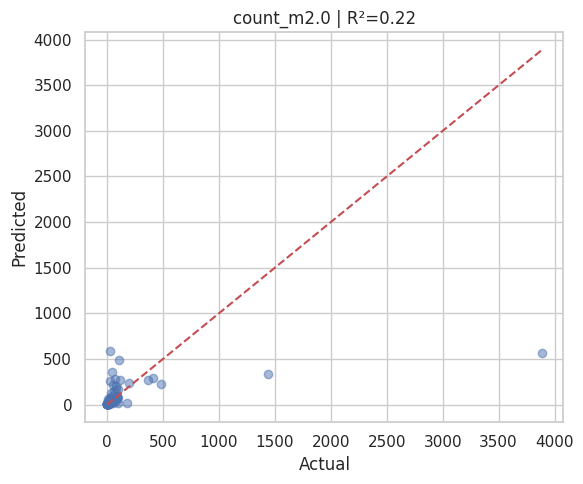

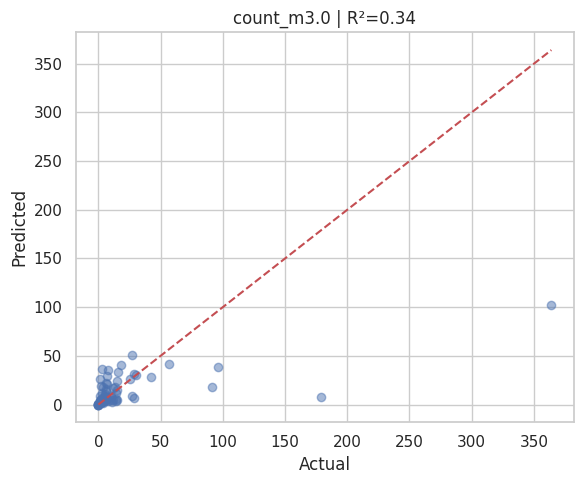

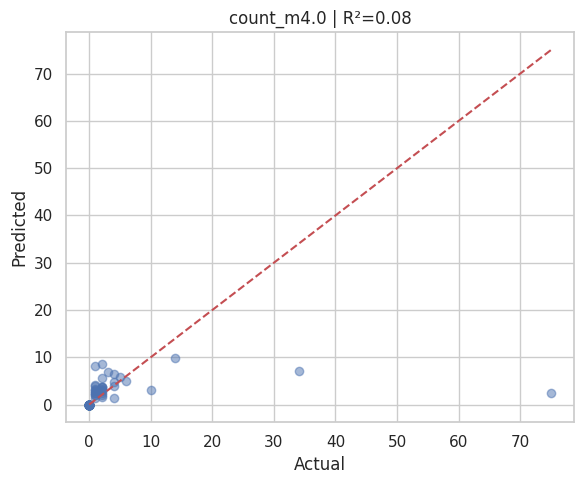

{'count_m2.0': {'MAE': 105.82455696202533, 'R2': 0.2225522749724036},
 'count_m3.0': {'MAE': 13.166329113924052, 'R2': 0.33580394518529055},
 'count_m4.0': {'MAE': 2.1, 'R2': 0.08218935208869327}}

In [ ]:
#trial 5: Temporal + Energy + Ratios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# === Step 1: Seismic history feature function ===
def compute_history(row, catalog, history_days=30, radius_km=100):
    t0 = row["mainshock_time"]
    lat0, lon0 = row["mainshock_lat"], row["mainshock_lon"]
    t_hist = t0 - pd.Timedelta(days=history_days)

    DEG_LAT_KM = 111
    lat_buffer = radius_km / DEG_LAT_KM
    lon_buffer = radius_km / DEG_LAT_KM

    mask = (
        (catalog["time"] < t0) &
        (catalog["time"] >= t_hist) &
        (catalog["latitude"] >= lat0 - lat_buffer) &
        (catalog["latitude"] <= lat0 + lat_buffer) &
        (catalog["longitude"] >= lon0 - lon_buffer) &
        (catalog["longitude"] <= lon0 + lon_buffer)
    )
    nearby = catalog[mask]

    count = len(nearby)
    avg_mag = nearby["magnitude"].mean() if count > 0 else 0
    energy = (10 ** (1.5 * nearby["magnitude"] + 4.8)).sum() if count > 0 else 0

    return pd.Series({
        'num_prior_events_30d': count,
        'avg_mag_prior_30d': avg_mag,
        'energy_release_prior_30d': energy
    })

# === Step 2: Add required features ===
data['mainshock_time'] = pd.to_datetime(data['mainshock_time'])
df['time'] = pd.to_datetime(df['time'])

# Temporal
data['hour'] = data['mainshock_time'].dt.hour
data['month'] = data['mainshock_time'].dt.month
data['day_of_year'] = data['mainshock_time'].dt.dayofyear
data['is_nighttime'] = data['hour'].apply(lambda h: h < 6 or h >= 20)
data['decade'] = (data['mainshock_time'].dt.year // 10) * 10

# Seismic history
history_feats = data.apply(lambda row: compute_history(row, df), axis=1)
data = pd.concat([data, history_feats], axis=1)

# Fill missing values
data.fillna({
    'num_prior_events_30d': 0,
    'avg_mag_prior_30d': 0.0,
    'energy_release_prior_30d': 0.0
}, inplace=True)

# === Step 3: Additional feature engineering ===
data['mainshock_energy'] = 10 ** (1.5 * data['mainshock_mag'] + 4.8)
data['log_energy'] = np.log1p(data['mainshock_energy'])

# Target ratios (safe division)
data['ratio_3_to_2'] = data['count_m3.0'] / data['count_m2.0'].replace(0, np.nan)
data['ratio_4_to_2'] = data['count_m4.0'] / data['count_m2.0'].replace(0, np.nan)
data.fillna(0, inplace=True)

# === Step 4: Modeling ===
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon', 'mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d',
    'log_energy', 'ratio_3_to_2', 'ratio_4_to_2'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = {}
for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target].max(), pred.max())], [0, max(y_test[target].max(), pred.max())], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final metrics
metrics


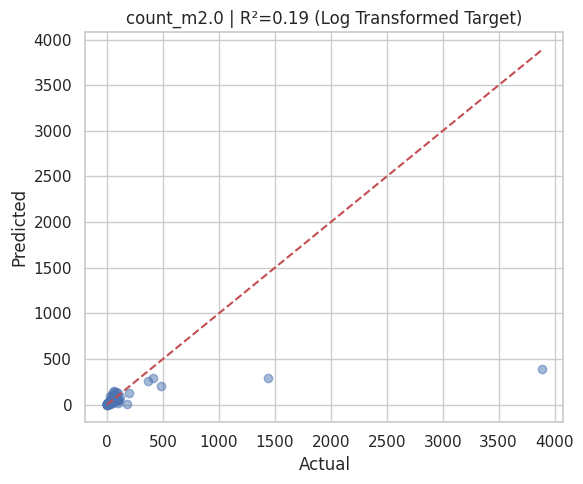

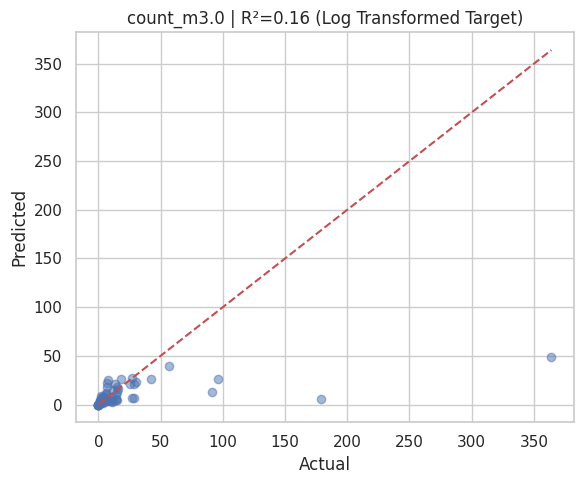

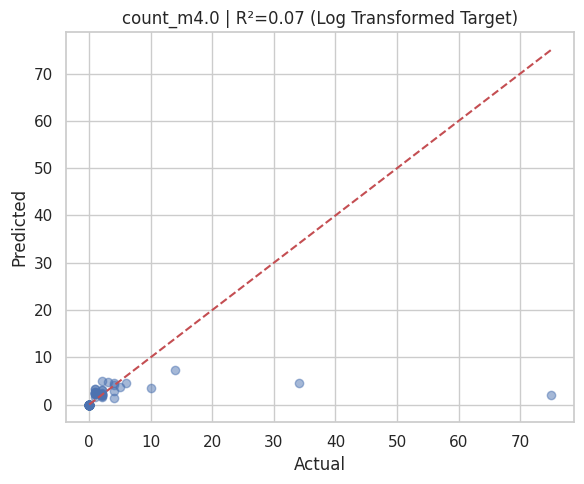

{'count_m2.0': {'MAE': 83.16842654560286, 'R2': 0.18554015386821565},
 'count_m3.0': {'MAE': 11.977681679512617, 'R2': 0.16332923007371014},
 'count_m4.0': {'MAE': 1.8736556749719395, 'R2': 0.06516176682839614}}

In [ ]:
#trial 6: Temporal + Energy + Ratios + LOG TRANSFORM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# === Step 1: Seismic history feature function ===
def compute_history(row, catalog, history_days=30, radius_km=100):
    t0 = row["mainshock_time"]
    lat0, lon0 = row["mainshock_lat"], row["mainshock_lon"]
    t_hist = t0 - pd.Timedelta(days=history_days)

    DEG_LAT_KM = 111
    lat_buffer = radius_km / DEG_LAT_KM
    lon_buffer = radius_km / DEG_LAT_KM

    mask = (
        (catalog["time"] < t0) &
        (catalog["time"] >= t_hist) &
        (catalog["latitude"] >= lat0 - lat_buffer) &
        (catalog["latitude"] <= lat0 + lat_buffer) &
        (catalog["longitude"] >= lon0 - lon_buffer) &
        (catalog["longitude"] <= lon0 + lon_buffer)
    )
    nearby = catalog[mask]

    count = len(nearby)
    avg_mag = nearby["magnitude"].mean() if count > 0 else 0
    energy = (10 ** (1.5 * nearby["magnitude"] + 4.8)).sum() if count > 0 else 0

    return pd.Series({
        'num_prior_events_30d': count,
        'avg_mag_prior_30d': avg_mag,
        'energy_release_prior_30d': energy
    })

# === Step 2: Add required features ===
data['mainshock_time'] = pd.to_datetime(data['mainshock_time'])
df['time'] = pd.to_datetime(df['time'])

# Temporal
data['hour'] = data['mainshock_time'].dt.hour
data['month'] = data['mainshock_time'].dt.month
data['day_of_year'] = data['mainshock_time'].dt.dayofyear
data['is_nighttime'] = data['hour'].apply(lambda h: h < 6 or h >= 20)
data['decade'] = (data['mainshock_time'].dt.year // 10) * 10

# Seismic history
history_feats = data.apply(lambda row: compute_history(row, df), axis=1)
data = pd.concat([data, history_feats], axis=1)

# Fill missing values
data.fillna({
    'num_prior_events_30d': 0,
    'avg_mag_prior_30d': 0.0,
    'energy_release_prior_30d': 0.0
}, inplace=True)

# === Step 3: Additional feature engineering ===
data['mainshock_energy'] = 10 ** (1.5 * data['mainshock_mag'] + 4.8)
data['log_energy'] = np.log1p(data['mainshock_energy'])
data['ratio_3_to_2'] = data['count_m3.0'] / data['count_m2.0'].replace(0, np.nan)
data['ratio_4_to_2'] = data['count_m4.0'] / data['count_m2.0'].replace(0, np.nan)
data.fillna(0, inplace=True)

# === Step 4: Modeling (log-transformed targets) ===
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon', 'mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d',
    'log_energy', 'ratio_3_to_2', 'ratio_4_to_2'
]
targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = {}
for target in targets:
    # === Log-transform the target ===
    y_train_log = np.log1p(y_train[target])

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_log)

    # Predict in log space, then invert
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target].max(), pred.max())], [0, max(y_test[target].max(), pred.max())], 'r--')
    plt.title(f'{target} | R²={r2:.2f} (Log Transformed Target)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final metrics
metrics



Fitting TweedieRegressor for: count_m2.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


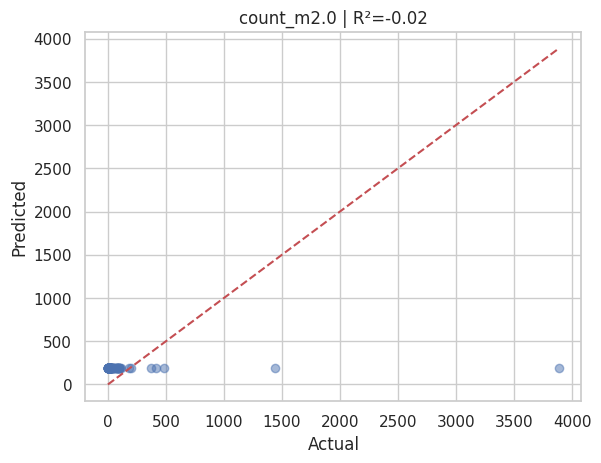


Fitting TweedieRegressor for: count_m3.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


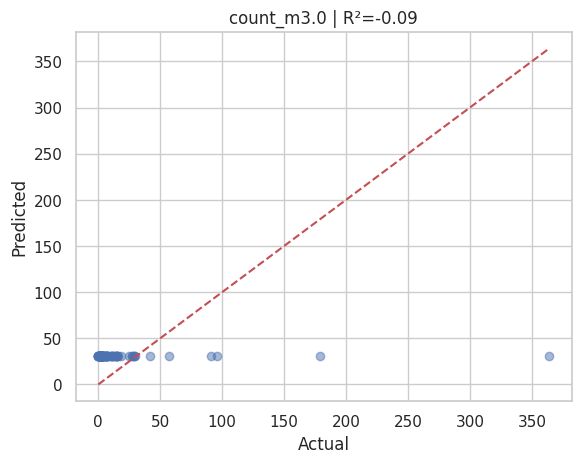


Fitting TweedieRegressor for: count_m4.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


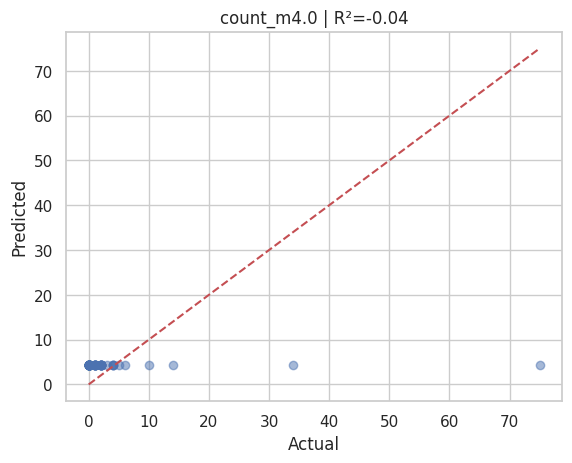


Tweedie Model Evaluation Metrics:
count_m2.0: MAE=213.70, R²=-0.02
count_m3.0: MAE=30.07, R²=-0.09
count_m4.0: MAE=4.76, R²=-0.04


In [ ]:
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Updated feature set (add 'mainshock_depth' if present) ===
features = [
    'mainshock_mag', 'mainshock_lat', 'mainshock_lon', 'mainshock_depth',
    'month', 'day_of_year', 'hour', 'is_nighttime', 'decade',
    'num_prior_events_30d', 'avg_mag_prior_30d', 'energy_release_prior_30d'
]

targets = ['count_m2.0', 'count_m3.0', 'count_m4.0']

X = data[features]
y = data[targets]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import TweedieRegressor

metrics = {}

for target in targets:
    print(f"\nFitting TweedieRegressor for: {target}")

    # Tweedie for compound Poisson-Gamma (suitable for skewed count data)
    model = TweedieRegressor(power=1.5, alpha=0.5)  # power=1.5 is compound Poisson
    model.fit(X_train, y_train[target])

    pred = model.predict(X_test)
    pred = np.clip(pred, 0, None)  # counts cannot be negative

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    # Plotting
    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

# Summary
print("\nTweedie Model Evaluation Metrics:")
for t, m in metrics.items():
    print(f"{t}: MAE={m['MAE']:.2f}, R²={m['R2']:.2f}")



Fitting TweedieRegressor for: count_m2.0


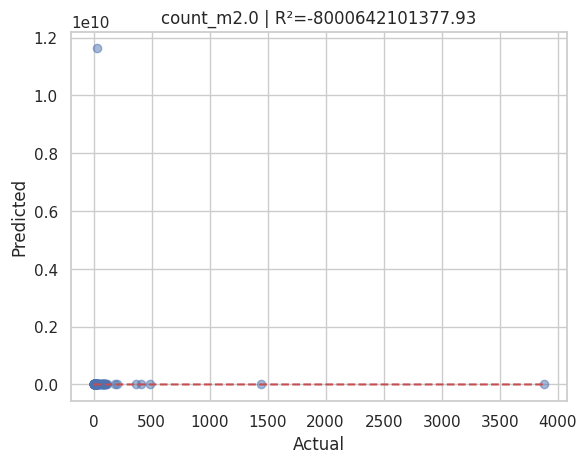


Fitting TweedieRegressor for: count_m3.0


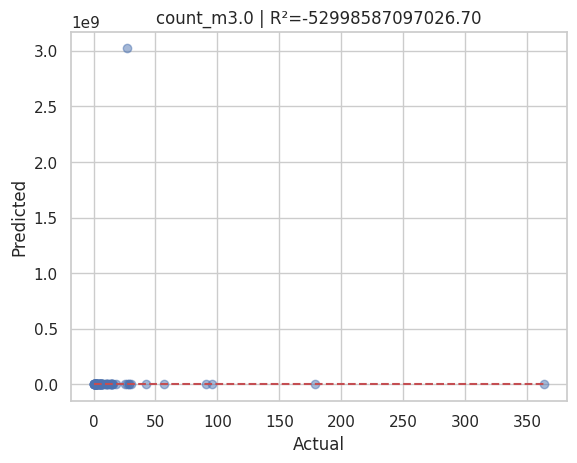


Fitting TweedieRegressor for: count_m4.0


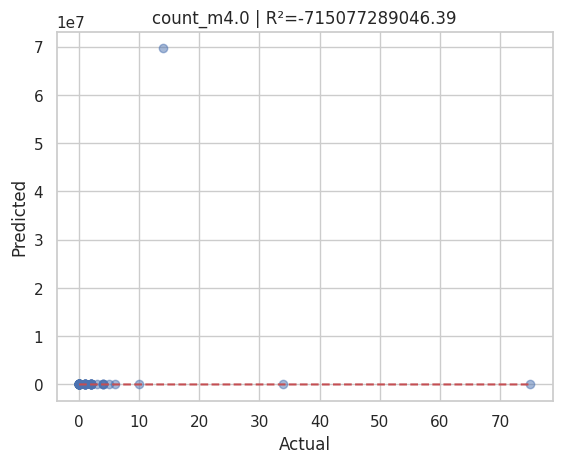


📊 Tweedie Regressor Evaluation Metrics:
count_m2.0: MAE = 147130051.88, R² = -8000642101377.93
count_m3.0: MAE = 38224142.69, R² = -52998587097026.70
count_m4.0: MAE = 881368.35, R² = -715077289046.39


In [ ]:
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Scale the input features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

metrics = {}

# === Loop through all targets ===
for target in targets:
    print(f"\nFitting TweedieRegressor for: {target}")

    model = TweedieRegressor(power=1.5, alpha=0.5, max_iter=1000)
    model.fit(X_train_scaled, y_train[target])

    pred = np.clip(model.predict(X_test_scaled), 0, None)

    mae = mean_absolute_error(y_test[target], pred)
    r2 = r2_score(y_test[target], pred)
    metrics[target] = {'MAE': mae, 'R2': r2}

    # Plot predictions
    plt.figure()
    plt.scatter(y_test[target], pred, alpha=0.5)
    plt.plot([0, max(y_test[target])], [0, max(y_test[target])], 'r--')
    plt.title(f'{target} | R²={r2:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

# === Print metrics nicely ===
print("\n📊 Tweedie Regressor Evaluation Metrics:")
for target, scores in metrics.items():
    print(f"{target}: MAE = {scores['MAE']:.2f}, R² = {scores['R2']:.2f}")


## 📊 Insights & Summary
- 🔥 Seismic history features (especially prior energy) are highly predictive.
- 📉 Mainshock magnitude matters, but is not the top driver.
- 🕒 Temporal features (like decade) help capture catalog evolution and patterns.
